## Import Libraries

In [1]:
#manipulate paths
import os

#Audio utilities libraries
from scipy.io import wavfile as wav
import librosa
import sounddevice as sd
import IPython.display as ipd

#sklearn utilities 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#numpy
import numpy as np

#plot libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
#import joblib

#keras for modeling
import keras
from keras import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Defining some functions

In [2]:
#Plot training metrics
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 
             color=colors[0],
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [3]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings2')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings2/' + f)
        
            cur_features = feature_extractor(signal, normalization = True)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)
        
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)           

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

In [4]:
duration = 2
rec_rate = 44100

def mfcc(input, rate=rec_rate, normalization = True):
   
    # Calcola coefficienti MFCC
    mfcc = np.mean(librosa.feature.mfcc(input, sr=rate, n_mfcc=20).T, axis=0)
    
    return mfcc

## FFNN Model

In [21]:
# Caricamento dati
X_train, X_test, y_train, y_test = load_data(feature_extractor=mfcc)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)           

In [23]:
print('train examples:', X_train.shape[0], '  train features:', X_train.shape[1])
print('val examples:', X_val.shape[0], '  val features:', X_val.shape[1])
print('test examples:', X_test.shape[0], '  test features:', X_test.shape[1])


train examples: 256   train features: 20
val examples: 64   val features: 20
test examples: 80   test features: 20


In [24]:
Y_train = np_utils.to_categorical(y_train,5)
Y_val = np_utils.to_categorical(y_val,5)
Y_test = np_utils.to_categorical(y_test,5)

In [25]:
 def make_model_FFNN():
        
        model = Sequential([
              Dense(32, 
                    activation='relu',
                    input_shape=(20,)),
              Dropout(0.2),
              Dense(64, 
                    activation='relu',
                    input_shape=(20,)),
              Dropout(0.2),
              Dense(5, 
                    activation='softmax'),
          ])

        model.compile(
              optimizer = Adam(),
              loss = categorical_crossentropy,
              metrics = ['accuracy'])

        return model

In [31]:
model_FFNN = make_model_FFNN()
model_FFNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 3,109
Trainable params: 3,109
Non-trainable params: 0
_________________________________________________________________


In [32]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

In [33]:
history_FFNN = model_FFNN.fit(
    X_train,
    Y_train,
    batch_size=16,
    validation_data = (X_val, Y_val),
    #callbacks = [early_stopping],
    epochs=300)

Train on 256 samples, validate on 64 samples
Epoch 1/300
256/256 [==============================] - 1s 3ms/step - loss: 29.3412 - accuracy: 0.1875 - val_loss: 7.1555 - val_accuracy: 0.2500
Epoch 2/300
256/256 [==============================] - 0s 198us/step - loss: 21.9131 - accuracy: 0.1992 - val_loss: 5.3971 - val_accuracy: 0.2969
Epoch 3/300
256/256 [==============================] - 0s 191us/step - loss: 17.0825 - accuracy: 0.2734 - val_loss: 2.6119 - val_accuracy: 0.3281
Epoch 4/300
256/256 [==============================] - 0s 198us/step - loss: 14.6542 - accuracy: 0.2344 - val_loss: 3.2472 - val_accuracy: 0.2969
Epoch 5/300
256/256 [==============================] - 0s 201us/step - loss: 11.1151 - accuracy: 0.2773 - val_loss: 3.7999 - val_accuracy: 0.2969
Epoch 6/300
256/256 [==============================] - 0s 202us/step - loss: 9.9317 - accuracy: 0.3008 - val_loss: 2.0581 - val_accuracy: 0.6094
Epoch 7/300
256/256 [==============================] - 0s 199us/step - loss: 9.812

Epoch 57/300
256/256 [==============================] - 0s 178us/step - loss: 0.4862 - accuracy: 0.8242 - val_loss: 0.4014 - val_accuracy: 0.8438
Epoch 58/300
256/256 [==============================] - 0s 174us/step - loss: 0.5237 - accuracy: 0.8281 - val_loss: 0.3918 - val_accuracy: 0.8594
Epoch 59/300
256/256 [==============================] - 0s 172us/step - loss: 0.4905 - accuracy: 0.8320 - val_loss: 0.3694 - val_accuracy: 0.8594
Epoch 60/300
256/256 [==============================] - 0s 179us/step - loss: 0.4832 - accuracy: 0.8555 - val_loss: 0.3391 - val_accuracy: 0.8750
Epoch 61/300
256/256 [==============================] - 0s 183us/step - loss: 0.5172 - accuracy: 0.8164 - val_loss: 0.3792 - val_accuracy: 0.8750
Epoch 62/300
256/256 [==============================] - 0s 178us/step - loss: 0.4747 - accuracy: 0.8477 - val_loss: 0.3422 - val_accuracy: 0.8906
Epoch 63/300
256/256 [==============================] - 0s 176us/step - loss: 0.3846 - accuracy: 0.8711 - val_loss: 0.3559 -

256/256 [==============================] - 0s 184us/step - loss: 0.2458 - accuracy: 0.9258 - val_loss: 0.2830 - val_accuracy: 0.9531
Epoch 114/300
256/256 [==============================] - 0s 188us/step - loss: 0.2118 - accuracy: 0.9297 - val_loss: 0.3068 - val_accuracy: 0.9531
Epoch 115/300
256/256 [==============================] - 0s 184us/step - loss: 0.2136 - accuracy: 0.9336 - val_loss: 0.2867 - val_accuracy: 0.9062
Epoch 116/300
256/256 [==============================] - 0s 175us/step - loss: 0.1968 - accuracy: 0.9297 - val_loss: 0.2709 - val_accuracy: 0.9219
Epoch 117/300
256/256 [==============================] - 0s 167us/step - loss: 0.1560 - accuracy: 0.9414 - val_loss: 0.2489 - val_accuracy: 0.9531
Epoch 118/300
256/256 [==============================] - 0s 174us/step - loss: 0.2654 - accuracy: 0.9102 - val_loss: 0.3008 - val_accuracy: 0.9219
Epoch 119/300
256/256 [==============================] - 0s 176us/step - loss: 0.2309 - accuracy: 0.9102 - val_loss: 0.3165 - val_ac

Epoch 169/300
256/256 [==============================] - 0s 181us/step - loss: 0.1205 - accuracy: 0.9570 - val_loss: 0.2683 - val_accuracy: 0.9531
Epoch 170/300
256/256 [==============================] - 0s 178us/step - loss: 0.1209 - accuracy: 0.9531 - val_loss: 0.2310 - val_accuracy: 0.9531
Epoch 171/300
256/256 [==============================] - 0s 172us/step - loss: 0.1212 - accuracy: 0.9648 - val_loss: 0.2365 - val_accuracy: 0.9375
Epoch 172/300
256/256 [==============================] - 0s 175us/step - loss: 0.1178 - accuracy: 0.9531 - val_loss: 0.2641 - val_accuracy: 0.9219
Epoch 173/300
256/256 [==============================] - 0s 169us/step - loss: 0.0772 - accuracy: 0.9688 - val_loss: 0.2668 - val_accuracy: 0.9375
Epoch 174/300
256/256 [==============================] - 0s 173us/step - loss: 0.0902 - accuracy: 0.9727 - val_loss: 0.2328 - val_accuracy: 0.9375
Epoch 175/300
256/256 [==============================] - 0s 164us/step - loss: 0.1081 - accuracy: 0.9609 - val_loss: 0

Epoch 225/300
256/256 [==============================] - 0s 181us/step - loss: 0.0993 - accuracy: 0.9766 - val_loss: 0.2637 - val_accuracy: 0.9219
Epoch 226/300
256/256 [==============================] - 0s 171us/step - loss: 0.0976 - accuracy: 0.9648 - val_loss: 0.2950 - val_accuracy: 0.9375
Epoch 227/300
256/256 [==============================] - 0s 167us/step - loss: 0.1087 - accuracy: 0.9570 - val_loss: 0.2687 - val_accuracy: 0.9375
Epoch 228/300
256/256 [==============================] - 0s 168us/step - loss: 0.0880 - accuracy: 0.9688 - val_loss: 0.3060 - val_accuracy: 0.9375
Epoch 229/300
256/256 [==============================] - 0s 172us/step - loss: 0.1062 - accuracy: 0.9570 - val_loss: 0.2859 - val_accuracy: 0.9375
Epoch 230/300
256/256 [==============================] - 0s 169us/step - loss: 0.1068 - accuracy: 0.9648 - val_loss: 0.2870 - val_accuracy: 0.9375
Epoch 231/300
256/256 [==============================] - 0s 166us/step - loss: 0.0907 - accuracy: 0.9766 - val_loss: 0

Epoch 281/300
256/256 [==============================] - 0s 174us/step - loss: 0.0620 - accuracy: 0.9883 - val_loss: 0.2794 - val_accuracy: 0.9375
Epoch 282/300
256/256 [==============================] - 0s 176us/step - loss: 0.0311 - accuracy: 0.9844 - val_loss: 0.2881 - val_accuracy: 0.9375
Epoch 283/300
256/256 [==============================] - 0s 179us/step - loss: 0.0736 - accuracy: 0.9688 - val_loss: 0.2922 - val_accuracy: 0.9375
Epoch 284/300
256/256 [==============================] - 0s 174us/step - loss: 0.0772 - accuracy: 0.9727 - val_loss: 0.3045 - val_accuracy: 0.9375
Epoch 285/300
256/256 [==============================] - 0s 171us/step - loss: 0.0650 - accuracy: 0.9766 - val_loss: 0.2696 - val_accuracy: 0.9375
Epoch 286/300
256/256 [==============================] - 0s 173us/step - loss: 0.0717 - accuracy: 0.9805 - val_loss: 0.2650 - val_accuracy: 0.9375
Epoch 287/300
256/256 [==============================] - 0s 185us/step - loss: 0.0550 - accuracy: 0.9805 - val_loss: 0

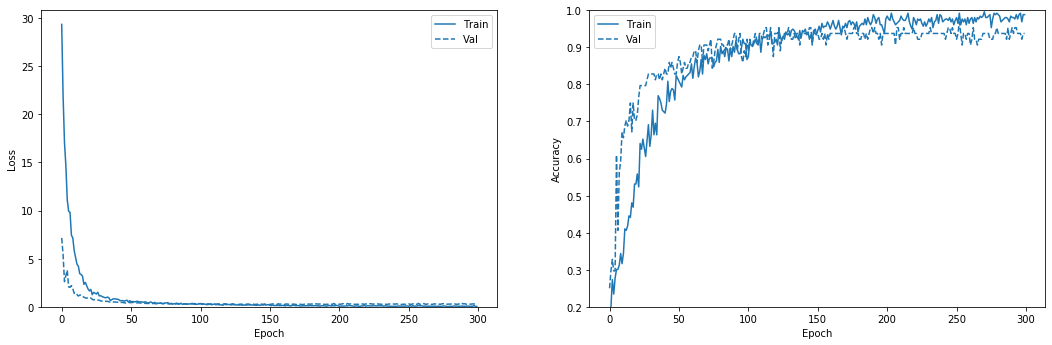

In [34]:
plot_metrics(history_FFNN)

Report di classificazione modello:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       0.87      1.00      0.93        13
           2       1.00      1.00      1.00        19
           3       0.94      0.94      0.94        16
           4       1.00      0.79      0.88        19

    accuracy                           0.94        80
   macro avg       0.93      0.95      0.94        80
weighted avg       0.94      0.94      0.94        80

Matrice di confusione modello:
[[13  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 19  0  0]
 [ 0  1  0 15  0]
 [ 2  1  0  1 15]]


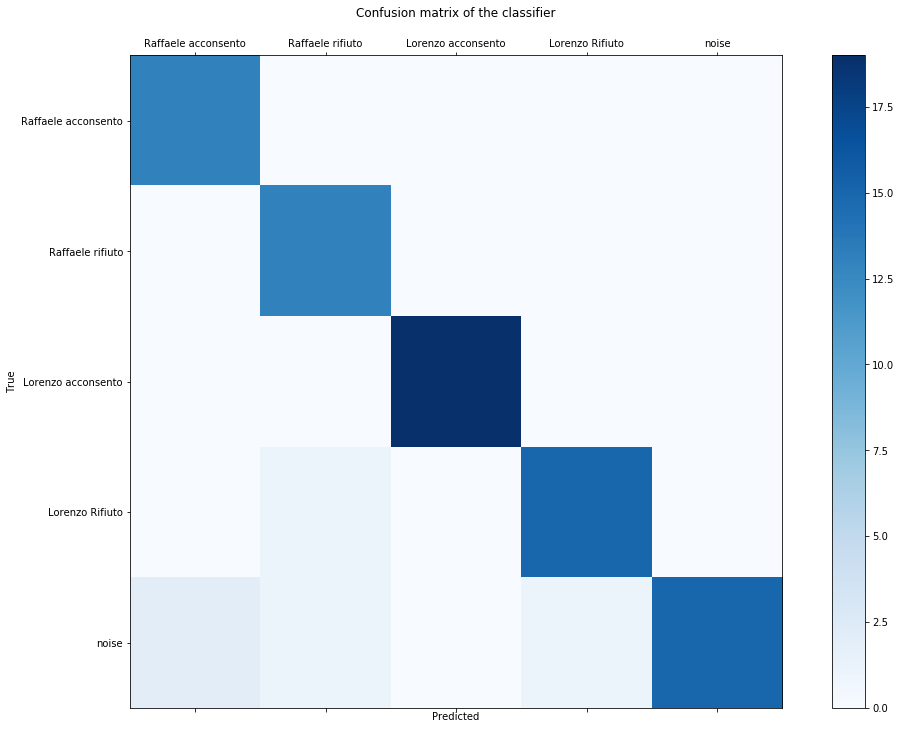

In [35]:
y_pred = model_FFNN.predict_classes(X_test) 
y_test = y_test.astype("int")
# Report di classificazione
print("Report di classificazione modello:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione modello:")
labels = ['Raffaele acconsento', 'Raffaele rifiuto', 'Lorenzo acconsento', 'Lorenzo Rifiuto', 'noise']
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.imshow(cm, cmap=plt.cm.Blues)




In [36]:
model_FFNN.save("FFNN.h5")

## Test Modello 

In [41]:
prova = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)
wav.write('test.wav', rec_rate, prova)
rec_rate, rec = wav.read('test.wav')

In [42]:
features = np.mean(librosa.feature.mfcc(rec*1.0, sr=int(rec_rate), n_mfcc=20).T, axis=0)
features = features.reshape(1, features.shape[0])

In [43]:
prob_audio = model_FFNN.predict(features)
if max(prob_audio[0]) < 0.7:   
    pred_audio = 4  
else:   
    pred_audio = np.argmax(prob_audio)

In [44]:
if pred_audio==0:
    print("Raffaele ha detto acconsento")
    
elif pred_audio == 1:
    print("Raffaele ha detto rifiuto")

elif pred_audio == 2:
    print("Lorenzo ha detto acconsento")
    
elif pred_audio == 3:
    print("Lorenzo ha detto rifiuto")
    
else:
    print("Riprova")
    
sent = prob_audio[0][pred_audio]
print("con probabilità:", sent)

Raffaele ha detto rifiuto
con probabilità: 0.9978523


In [20]:
ipd.Audio(rec, rate=44100)